In [1]:
import numpy as np
import cv2

In [2]:
from matplotlib import pyplot as plt

### Question 3

In [3]:
# note: make sure to pass an RGB image and not BGR
def H_func(image, epsilon=1e-8):
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]

    # getting theta values per pixel
    numerator = 0.5 * (R - G + R - B)
    denominator = np.sqrt((R - G) ** 2 + (R - B) * (G - B)) + epsilon
    theta = np.arccos(numerator / denominator)
    
    new_pixel_values = np.where(B <= G, theta, 360 - theta) / 360
    return new_pixel_values

def S_func(image, epsilon=1e-8):
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    return 1 - (3 / (R + G + B + epsilon)) * np.min(image, axis=2)

def I_func(image):
    return np.mean(image, axis=2)  # averaging RGB values

In [4]:
image_file_path = './lena.jpg'

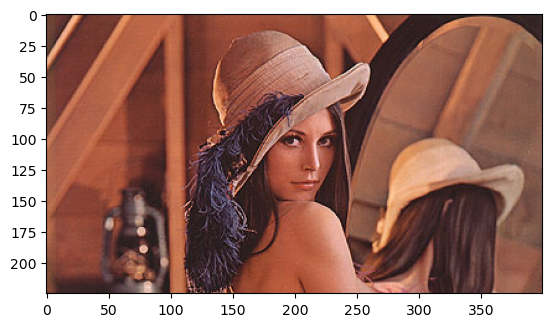

In [5]:
# cv2 reads in BGR format so we're reversing the channels to be RGB
img = cv2.imread(image_file_path)[..., ::-1] / 255
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow((img * 255).astype(np.uint8))

In [6]:
H = H_func(img)
S = S_func(img)
I = I_func(img)
# add all channels together
new_img = np.stack([H, S, I], axis=-1)

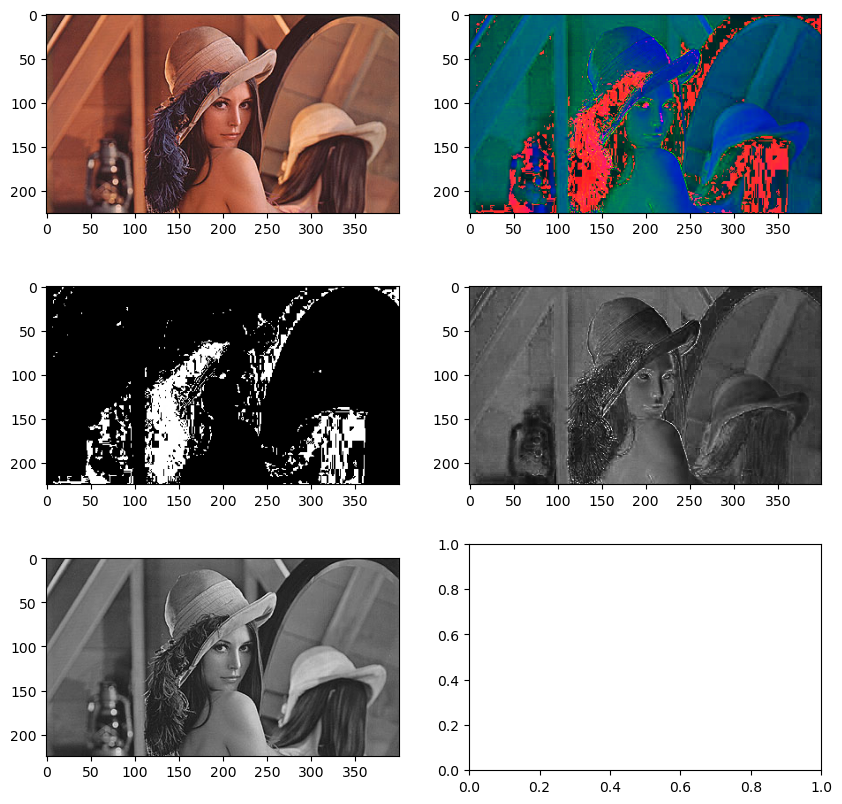

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes[0, 0].imshow(img)
axes[0, 1].imshow(new_img)
axes[1, 0].imshow(H, cmap='gray')
axes[1, 1].imshow(S, cmap='gray')
axes[2, 0].imshow(I, cmap='gray')

 ### Question 4

In [8]:
floyd_steinberg_kernel = np.array([[
    [0, 0, 0],
    [0, 0, 7/16],
    [3/16, 5/16, 1/16]
]])

In [9]:
def get_closest_vector(vector, channel_vectors):
    distances = distances = np.sqrt(np.square(vector - channel_vectors).sum(axis=1))
    return channel_vectors[np.argmin(distances)]

In [10]:
# will be used for easier usage in the kernel multiplication
def symmetric_padding(image, pad_value=0):
    height, width, n_channels = image.shape
    # padded image will have 2 more rows and columns for each color channel
    padded_image = np.zeros((height + 2, width + 2, n_channels))
    # padding 2D tensors from right & left and from top & bottom
    for c in range(n_channels):
        padded_image[..., c] = np.pad(image[..., c], 1, mode='constant', constant_values=pad_value)
    return padded_image

In [11]:
def floyd_steinberg_on_pixel(original_pixel_coordinates, closest_pixel, padded_image, dithered_image):
    h, w = original_pixel_coordinates
    padded_h, padded_w = h+1, w+1
    # if values in the vector are larger/equal than 128 set it to 255, else set to 0
    dithered_image[h, w, :] = 255 * (dithered_image[h, w, :] >= 128)
    # calculate diff with the "original" image which is the padded image
    diff = padded_image[padded_h-1:padded_h+2, padded_w-1:padded_w+2, :] - closest_pixel
    # update the dithered image with the delta across all channels
    dithered_image[padded_h-1:padded_h+2, padded_w-1:padded_w+2, :] += diff * floyd_steinberg_kernel

In [12]:
def custom_error_diffusion(image, channel_vectors):
    if len(channel_vectors) == 0:
        raise Exception("channel_vectors can't be empty!")
    
    final_image = np.empty_like(image)
    # padding the original image with zeros along the width and height axes (not color channels) for faster usage of kernel multiplication
    padded_image = symmetric_padding(image=image, pad_value=0) # symmetric_padding(image=image, target_shape=(image.shape[0]+2, image.shape[1]+2, image.shape[2]), pad_value=0)
    dithered_image = padded_image.copy()

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel = image[y, x]
            closest_vector = get_closest_vector(pixel, channel_vectors)
            # set closest vector in final_image as-is
            final_image[y, x] = closest_vector
            # execute error diffusion on dithered_image on that pixel
            floyd_steinberg_on_pixel((y, x), closest_vector, padded_image, dithered_image)

    return final_image

In [13]:
r = np.array([255, 0, 0])
g = np.array([0, 255, 0])
b = np.array([0, 0, 255])
channel_vectors = np.array([r, g])

In [14]:
result_image = custom_error_diffusion(img, channel_vectors)

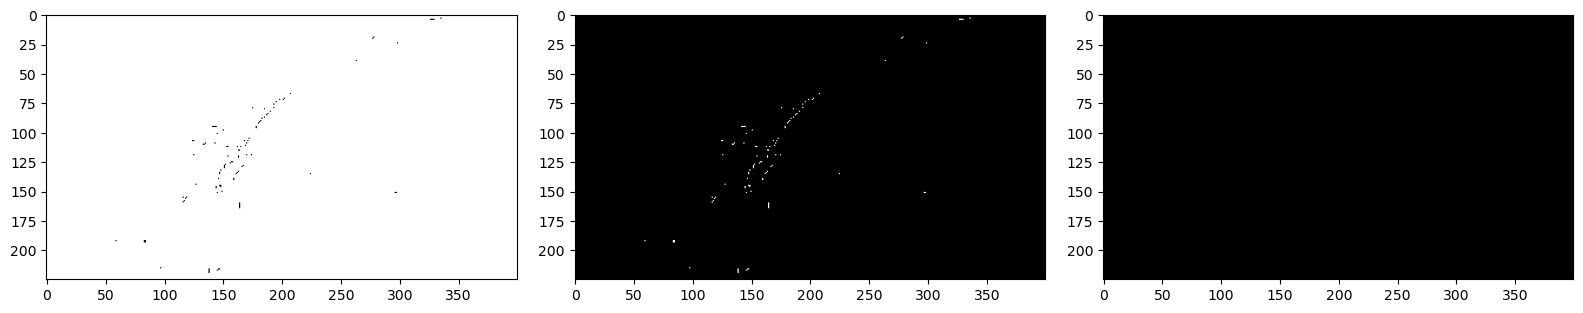

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
fig.tight_layout()

for i in range(result_image.shape[-1]):
    axes[i].imshow(result_image[..., i], cmap='gray')

In [16]:
def find_closest_pixel(pixel_coordinates, filtered_channeled_image, grid):
    y0, x0 = pixel_coordinates
    pixel = filtered_channeled_image[y0, x0, :]
    _, cols, _ = filtered_channeled_image.shape
    # getting a mask of the indices we want to work with
    yy, xx = grid
    row_mask = yy == y0
    col_mask = xx == x0

    different_pixels_mask = ~(row_mask & col_mask)
    different_pixels = filtered_channeled_image[different_pixels_mask, :]
    # flattenning the image to easier distance calculation
    filtered_channeled_image = filtered_channeled_image.reshape(-1, 3)
    # find closest pixel that's not equal to the pixel itself
    distances = np.sqrt((different_pixels - pixel)**2).sum(axis=1)
    closest_pixel_idx = np.argmin(distances)
    # if it's "after" the checked pixel, its' original indices is 1 more than in the masked image
    if closest_pixel_idx >= x0 * y0:
        closest_pixel_idx += 1
    
    row_idx, col_idx = closest_pixel_idx // cols, closest_pixel_idx % cols
    return np.array([row_idx, col_idx])

In [17]:
def n_channels_floyd_steinberg(image: np.array) -> np.array:
    # using the original pixel values as a starting point for the dithered image
    dithered_image = image.copy()
    # shape is of type H x W x C
    n_channels = image.shape[-1]
    # for each channel we'll execute the floyd steinberg algorithm
    for c in range(n_channels):
        current_channel = dithered_image[..., c]
        for h in range(image.shape[0]):
            for w in range(image.shape[1]):
                dithered_image[h, w, c] = 255 if current_channel[h, w] > 128 else 0
                # getting the difference with the *original* pixel value in the current channel
                diff = image[h, w, c] - dithered_image[h, w, c]
                for row, col, fraction in [(0, 1, 7/16), (1, 1, 1/16), (1, 0, 5/16), (1, -1, 3/16)]:
                    if image.shape[0] > h + row >= 0 and image.shape[1] > w + col >= 0:
                        dithered_image[h + row, w + col, c] += diff * fraction
    return dithered_image.astype(np.uint8)

In [18]:
new_image = n_channels_floyd_steinberg(img * 255)

Text(0.5, 1.0, 'RGB')

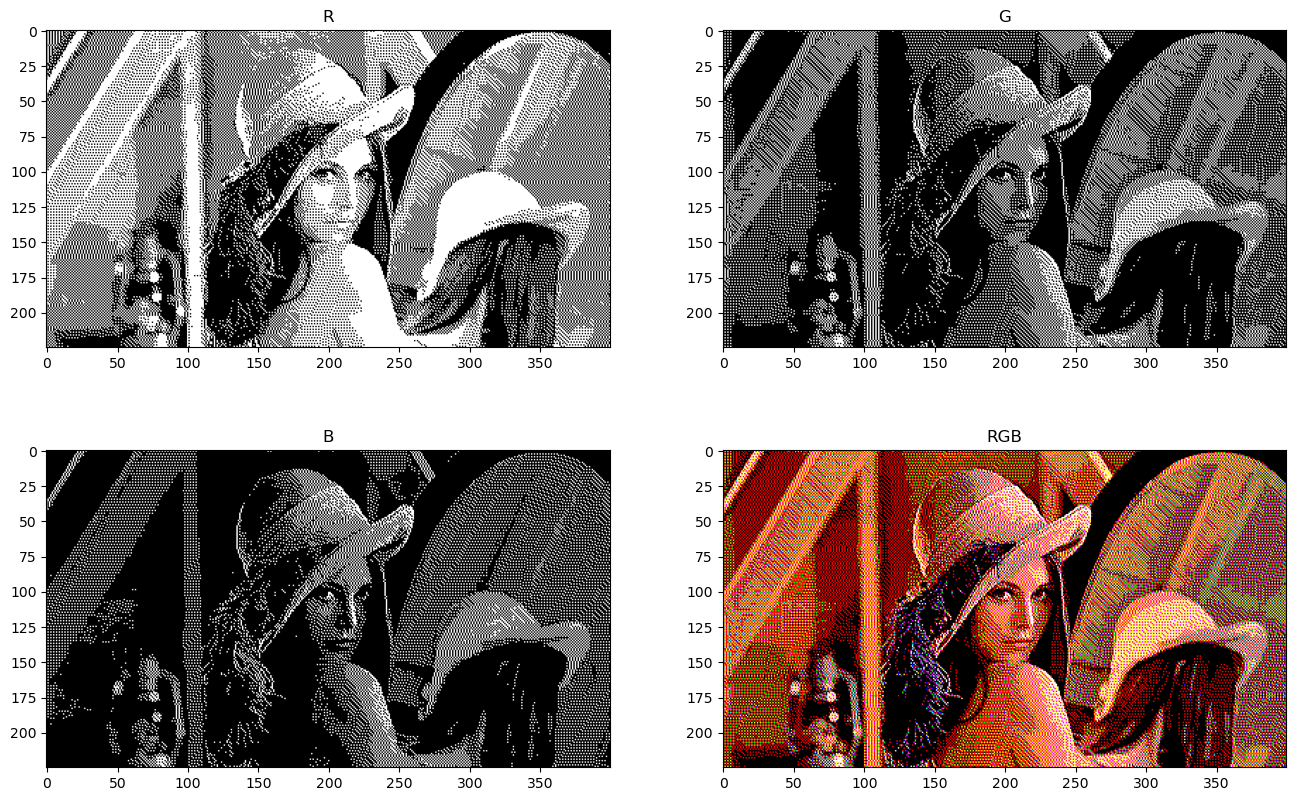

In [19]:
_, axes = plt.subplots(2, 2, figsize=(16, 10))
axes[0, 0].imshow(new_image[..., 0], cmap='gray')
axes[0, 0].set_title('R')
axes[0, 1].imshow(new_image[..., 1], cmap='gray')
axes[0, 1].set_title('G')
axes[1, 0].imshow(new_image[..., 2], cmap='gray')
axes[1, 0].set_title('B')
axes[1, 1].imshow(new_image)
axes[1, 1].set_title('RGB')